# ResNet50 Model Trained with Transfer Learning

This file is used to train a ResNet50 model with transfer learning on the adapted cars dataset (49 classes, images cropped around the bounding boxes, and 50% more training data). 

We used a model with weights pre-trained on the ImageNet dataset.

In [1]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.models import Sequential
from keras.applications import ResNet50
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [12]:
IMAGE_SIZE = 224
IMAGE_SHAPE = (224, 224, 3)
#classes = 196
classes = 49
seed = 42

train_path = 'C:/Users/Khoi/Downloads/car_data/train'
test_path = 'C:/Users/Khoi/Downloads/car_data/test'

In [13]:
gen_params = {"rescale":1.0/255,
              "featurewise_center":False,
              "samplewise_center":False,
              "featurewise_std_normalization":False,
              "samplewise_std_normalization":False,
              "zca_whitening":False,
              "rotation_range":20,
              "width_shift_range":0.1,
              "height_shift_range":0.1,
              "shear_range":0.2,
              "zoom_range":0.1,
              "horizontal_flip":True,
              "fill_mode":'constant',
              "cval": 0,
              "validation_split":0.2}

train_datagen = ImageDataGenerator(**gen_params)
test_datagen = ImageDataGenerator(rescale = 1/255.0)

training_set = train_datagen.flow_from_directory(train_path,
                                                  target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                  batch_size = 32,
                                                  class_mode = 'categorical',
                                                  color_mode='rgb',
                                                  shuffle = True,
                                                  subset='training',
                                                  seed=seed)

validation_set = train_datagen.flow_from_directory(train_path,
                                                  target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                  batch_size = 32,
                                                  class_mode = 'categorical',
                                                  color_mode='rgb',
                                                  shuffle =True,
                                                  subset='validation',
                                                  seed=seed)

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            color_mode='rgb',
                                            shuffle =True,
                                            seed=seed)

Found 9743 images belonging to 49 classes.
Found 2416 images belonging to 49 classes.
Found 4026 images belonging to 49 classes.


In [14]:
model_name = "resnet50_cars_2.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, 
                                             monitor='val_loss',
                                             verbose=0,
                                             save_best_only=True,
                                             save_weights_only=True,
                                             mode='min')

# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [15]:
base_model = ResNet50(weights='imagenet',
                      input_shape=IMAGE_SHAPE,
                      include_top=False)

In [16]:
base_model.trainable = False
#for layers in base_model.layers[:143]:
    #layer.trainable = False

In [17]:
x = base_model.output
x = Flatten()(x)
prediction = Dense(classes, activation='softmax')(x)

In [18]:
model=Model(inputs=base_model.input, outputs=prediction)

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [20]:
h = model.fit(training_set,
              validation_data = validation_set,
              steps_per_epoch=len(training_set),
              epochs=200,
              verbose=1,
             callbacks=[early_stop, lr_schedule, monitor])

Epoch 1/200
305/305 [==============================] - 135s 443ms/step - loss: 3.6745 - accuracy: 0.0946 - val_loss: 3.5671 - val_accuracy: 0.1217
Epoch 2/200
305/305 [==============================] - 133s 436ms/step - loss: 3.5304 - accuracy: 0.1125 - val_loss: 3.5563 - val_accuracy: 0.1084
Epoch 3/200
305/305 [==============================] - 131s 431ms/step - loss: 3.4830 - accuracy: 0.1161 - val_loss: 3.4655 - val_accuracy: 0.1345
Epoch 4/200
305/305 [==============================] - 131s 430ms/step - loss: 3.4095 - accuracy: 0.1334 - val_loss: 3.4002 - val_accuracy: 0.1225
Epoch 5/200
305/305 [==============================] - 131s 429ms/step - loss: 3.2149 - accuracy: 0.1542 - val_loss: 3.3095 - val_accuracy: 0.1337
Epoch 6/200
305/305 [==============================] - 131s 428ms/step - loss: 3.2007 - accuracy: 0.1528 - val_loss: 3.2497 - val_accuracy: 0.1643
Epoch 7/200
305/305 [==============================] - 130s 427ms/step - loss: 3.1795 - accuracy: 0.1566 - val_loss: 3

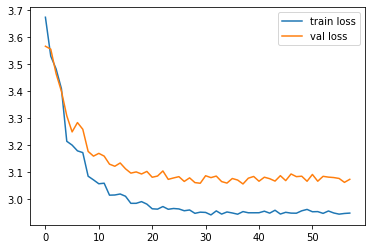

In [21]:
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='val loss')
plt.legend()
plt.show()

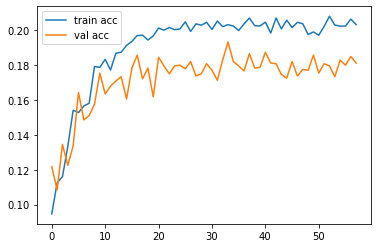

In [22]:
plt.plot(h.history['accuracy'], label='train acc')
plt.plot(h.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [23]:
metrics = model.evaluate(test_set)

126/126 [==============================] - 16s 127ms/step - loss: 2.9421 - accuracy: 0.2131
